# McDonalds NLP Project

# Abstract:
Executive summary McDonald's is the world's largest chain of fast-food restaurants, serving
around 68 million customers daily in 119 countries across more than 36,000 outlets. Founded in
the United States in 1940, A McDonald's restaurant is operated by a franchisee, an affiliate, or
the corporation itself. In this project we have done a sentiment analysis of negative McDonald's
reviews. Contributors were given reviews culled from low-rated McDonald's from random metro
areas and asked to classify why the locations received low reviews. 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS


from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
df=pd.read_csv('McDonalds.csv')
df.head()

_unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0  679455653    False   finalized                   3      2/21/15 0:36   
1  679455654    False   finalized                   3      2/21/15 0:27   
2  679455655    False   finalized                   3      2/21/15 0:26   
3  679455656    False   finalized                   3      2/21/15 0:27   
4  679455657    False   finalized                   3      2/21/15 0:27   

                   policies_violated policies_violated:confidence     city  \
0  RudeService\rOrderProblem\rFilthy          1.0\r0.6667\r0.6667  Atlanta   
1                        RudeService                            1  Atlanta   
2          SlowService\rOrderProblem                     1.0\r1.0  Atlanta   
3                                 na                       0.6667  Atlanta   
4                        RudeService                            1  Atlanta   

   policies_violated_gold                                             review  
0                     NaN  I'm not a huge mcds lover, but I've been to be...  
1                     NaN  Terrible customer service. ξI came in at 9:30p...  
2                     NaN  First they "lost" my order, actually they gave...  
3                     NaN  I see I'm not the only one giving 1 star. Only...  
4                     NaN  Well, it's McDonald's, so you know what the fo...

In [3]:
df.policies_violated.value_counts()

na                                        295
RudeService                               177
SlowService                               127
OrderProblem                              116
BadFood                                   101
                                         ... 
BadFood\rRudeService\rCost                  1
Cost\rBadFood\rOrderProblem                 1
BadFood\rRudeService\rSlowService           1
na\rBadFood                                 1
SlowService\rOrderProblem\rMissingFood      1
Name: policies_violated, Length: 146, dtype: int64

In [4]:
df.drop(['_unit_id'], axis = 1, inplace = True)
df.drop(['_golden'], axis = 1, inplace = True)
df.drop(['_unit_state'], axis = 1, inplace = True)
df.drop(['_trusted_judgments'], axis = 1, inplace = True)
df.drop(['_last_judgment_at'], axis = 1, inplace = True)
df.drop(['policies_violated'], axis = 1, inplace = True)
df.drop(['policies_violated:confidence'], axis = 1, inplace = True)
df.drop(['city'], axis = 1, inplace = True)
df.drop(['policies_violated_gold'], axis = 1, inplace = True)

In [5]:
df.head(30)

review
0   I'm not a huge mcds lover, but I've been to be...
1   Terrible customer service. ξI came in at 9:30p...
2   First they "lost" my order, actually they gave...
3   I see I'm not the only one giving 1 star. Only...
4   Well, it's McDonald's, so you know what the fo...
5   This has to be one of the worst and slowest Mc...
6   I'm not crazy about this McDonald's. ξThis is ...
7   One Star and I'm beng kind. I blame management...
8   Never been upset about any fast food drive thr...
9   This McDonald's has gotten much better. Usuall...
10  Let's start here only reason I came into McDon...
11  Other businesses throughout Metro Atlanta open...
12  The drive thru makes them lost a star since my...
13  Believe it or not, this used to be q really go...
14  As the previous yelpers have already stated, t...
15  25 minutes in drive through line. Gunshots fro...
16  Super slow service, food's terrible like its b...
17  SLOW-SLOW-SLOW! ξDon't go here if you have a f...
18  On your way to the airport or just cruising do...
19  This is the worst McDonalds I have ever seen. ...
20  I had the McCafe Mocha and must say that it wa...
21  GHETTO!! went in yesterday just to get a soda ...
22  I visited mcdonalds on Dec 20, 2011 at 12:54 I...
23  I usually hit the drive thru once or twice a w...
24  What a joke.Don't do take out as you will not ...
25  I wish I can give zero stars. Freezing cold re...
26  I agree with most reviewers on this one. Staff...
27  I don't think this location deserves even one ...
28  This is one rude Mcdonalds! The food takes lon...
29  the managers at this mcdonalds are awesome but...

In [6]:
# There are 1525 reviews in the dataset
len(df)

1525

In [7]:
df.value_counts()

review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# for text pre-processing

In [8]:

def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

def stopword(string):
    stop_words = stopwords.words('english')
    stop_words.extend(['ξI', ' ξ'])
    a= [i for i in string.split() if i not in stop_words]
    return ' '.join(a)


lemma = WordNetLemmatizer()
def lemmatizer(string):
    a=[lemma.lemmatize(i) for i in word_tokenize(string) ]
    return " ".join(a)


In [9]:
df['clean_text_stopward'] = df['review'].apply(lambda x: stopword(x))

In [10]:
df.head()

review  \
0  I'm not a huge mcds lover, but I've been to be...   
1  Terrible customer service. ξI came in at 9:30p...   
2  First they "lost" my order, actually they gave...   
3  I see I'm not the only one giving 1 star. Only...   
4  Well, it's McDonald's, so you know what the fo...   

                                 clean_text_stopward  
0  I'm huge mcds lover, I've better ones. This fa...  
1  Terrible customer service. came 9:30pm stood f...  
2  First "lost" order, actually gave someone one ...  
3  I see I'm one giving 1 star. Only -25 Star!!! ...  
4  Well, McDonald's, know food is. ξThis review r...

In [11]:
df['clean_text'] = df['review'].apply(lambda x: lemmatizer(stopword(preprocess(x))))

In [12]:
df.head()

review  \
0  I'm not a huge mcds lover, but I've been to be...   
1  Terrible customer service. ξI came in at 9:30p...   
2  First they "lost" my order, actually they gave...   
3  I see I'm not the only one giving 1 star. Only...   
4  Well, it's McDonald's, so you know what the fo...   

                                 clean_text_stopward  \
0  I'm huge mcds lover, I've better ones. This fa...   
1  Terrible customer service. came 9:30pm stood f...   
2  First "lost" order, actually gave someone one ...   
3  I see I'm one giving 1 star. Only -25 Star!!! ...   
4  Well, McDonald's, know food is. ξThis review r...   

                                          clean_text  
0  huge mcds lover better one far worst one ever ...  
1  terrible customer service ξi came pm stood fro...  
2  first lost order actually gave someone one els...  
3                  see one giving star star need say  
4  well mcdonald know food ξthis review reflects ...

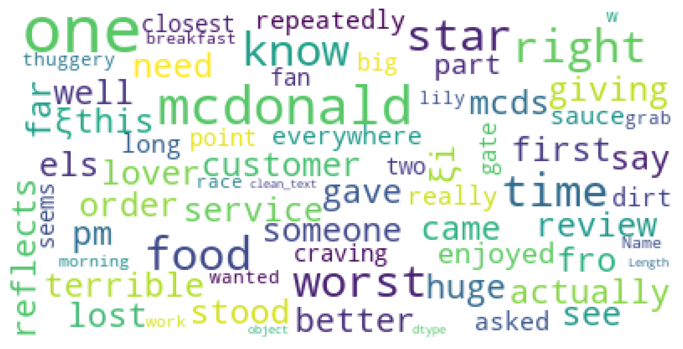

In [13]:
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df['clean_text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [14]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['clean_text_stopward'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 unigrams in the Macdonalds review after removing stop words and lemmatization"))
fig.show()

In [15]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['clean_text_stopward'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the Macdonalds review after removing stop words and lemmatization"))
fig.show()

In [16]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df['clean_text_stopward'], 20)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 trigrams in the Macdonalds review "))
fig.show()

In [17]:
vectorizer = CountVectorizer(stop_words='english')
doc_word = vectorizer.fit_transform(df['clean_text_stopward'])
doc_word.shape

(1525, 8529)

In [18]:
words = list(np.asarray(vectorizer.get_feature_names()))

In [19]:
pd.DataFrame(doc_word.toarray(), index= df['clean_text_stopward'], columns=vectorizer.get_feature_names()).head(10)

00  000  00am  00my  00pm  \
clean_text_stopward                                                             
I'm huge mcds lover, I've better ones. This far...   0    0     0     0     0   
Terrible customer service. came 9:30pm stood fr...   0    0     0     0     0   
First "lost" order, actually gave someone one e...   0    0     0     0     0   
I see I'm one giving 1 star. Only -25 Star!!! T...   0    0     0     0     0   
Well, McDonald's, know food is. ξThis review re...   0    0     0     0     0   
This one worst slowest McDonald's franchises is...   0    0     0     0     0   
I'm crazy McDonald's. ξThis primarily slow. ξMy...   0    0     0     0     0   
One Star I'm beng kind. I blame management. las...   0    0     0     0     0   
Never upset fast food drive thru service till I...   0    0     0     0     0   
This McDonald's gotten much better. Usually ord...   0    0     0     0     0   

                                                    01  0200  03pm  04  04am  \
clean_text_stopward                                                            
I'm huge mcds lover, I've better ones. This far...   0     0     0   0     0   
Terrible customer service. came 9:30pm stood fr...   0     0     0   0     0   
First "lost" order, actually gave someone one e...   0     0     0   0     0   
I see I'm one giving 1 star. Only -25 Star!!! T...   0     0     0   0     0   
Well, McDonald's, know food is. ξThis review re...   0     0     0   0     0   
This one worst slowest McDonald's franchises is...   0     0     0   0     0   
I'm crazy McDonald's. ξThis primarily slow. ξMy...   0     0     0   0     0   
One Star I'm beng kind. I blame management. las...   0     0     0   0     0   
Never upset fast food drive thru service till I...   0     0     0   0     0   
This McDonald's gotten much better. Usually ord...   0     0     0   0     0   

                                                    ...  ξyeah  ξyears  ξyelp  \
clean_text_stopward                                 ...                         
I'm huge mcds lover, I've better ones. This far...  ...      0       0      0   
Terrible customer service. came 9:30pm stood fr...  ...      0       0      0   
First "lost" order, actually gave someone one e...  ...      0       0      0   
I see I'm one giving 1 star. Only -25 Star!!! T...  ...      0       0      0   
Well, McDonald's, know food is. ξThis review re...  ...      0       0      0   
This one worst slowest McDonald's franchises is...  ...      0       0      0   
I'm crazy McDonald's. ξThis primarily slow. ξMy...  ...      0       0      0   
One Star I'm beng kind. I blame management. las...  ...      0       0      0   
Never upset fast food drive thru service till I...  ...      0       0      0   
This McDonald's gotten much better. Usually ord...  ...      0       0      0   

                                                    ξyep  ξyes  ξyesterday  \
clean_text_stopward                                                          
I'm huge mcds lover, I've better ones. This far...     0     0           0   
Terrible customer service. came 9:30pm stood fr...     0     0           0   
First "lost" order, actually gave someone one e...     0     0           0   
I see I'm one giving 1 star. Only -25 Star!!! T...     0     0           0   
Well, McDonald's, know food is. ξThis review re...     0     0           0   
This one worst slowest McDonald's franchises is...     0     0           0   
I'm crazy McDonald's. ξThis primarily slow. ξMy...     0     0           0   
One Star I'm beng kind. I blame management. las...     0     0           0   
Never upset fast food drive thru service till I...     0     0           0   
This McDonald's gotten much better. Usually ord...     0     0           0   

                                                    ξyet  ξyou  ξyour  ξyours  
clean_text_stopward                                                            
I'm huge mcds lover, I've better ones. This far.

In [20]:
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(doc_word)

In [21]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [22]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
order, mcdonald, food, drive, time, like, service, mcdonalds, place, people

Topic  1
mcdonald, like, review, mcwrap, fries, people, old, north, ξand, way

Topic  2
food, mcdonalds, place, fast, service, eat, like, good, people, want

Topic  3
food, order, fast, mcdonald, service, window, waiting, customers, time, longer

Topic  4
order, time, fries, manager, coffee, minutes, waiting, counter, ordered, chicken

Topic  5
fries, food, chicken, ordered, window, drive, asked, got, said, went

Topic  6
coffee, food, window, line, burned, cream, got, waiting, morning, wanted

Topic  7
mcdonalds, service, mcdonald, customer, fries, breakfast, employee, manager, ξthe, worst

Topic  8
time, mcdonalds, drive, line, minutes, fries, wait, 10, north, ve

Topic  9
people, line, window, like, waiting, minutes, mcdonalds, place, lot, north


In [23]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(doc_word)

In [24]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
order, time, wrong, minutes, right, breakfast, wait, window, ordered, waiting

Topic  1
mcdonald, review, people, ve, know, way, line, ξthe, say, good

Topic  2
food, fast, time, waiting, eat, restaurant, customers, line, fresh, quick

Topic  3
mcdonalds, ve, breakfast, good, want, really, people, ξthe, employee, pretty

Topic  4
drive, window, car, way, inside, went, cars, location, sure, said

Topic  5
fries, chicken, ordered, got, said, ξthe, went, cold, asked, meal

Topic  6
coffee, burned, iced, morning, breakfast, cream, hot, time, starbucks, line

Topic  7
place, time, people, location, staff, ve, really, kids, inside, work

Topic  8
like, mcd, want, people, really, sweet, eating, old, shake, looks

Topic  9
service, customer, location, ve, manager, worst, bad, slow, times, rude


In [25]:
# gensim
from gensim import corpora, models, similarities, matutils

# sklearn

from sklearn.feature_extraction.text import CountVectorizer

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

C:\Users\njood\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning:

The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.



In [26]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [27]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# Build LDA model using Sklearn

In [28]:
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(doc_word )

print(lda_model)  # Model attributes

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [29]:

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(doc_word))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(doc_word))

# See model parameters
pprint(lda_model.get_params())

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Log Likelihood:  -505943.7270062459
Perplexity:  2755.1114122684403
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


# Tune number of topics and learning decay (controls learning rate) using GridSearchCV

In [30]:
# Define Search Param
search_params = {'n_components': [9, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_word)

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:443: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:93: DeprecationW

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [9, 8, 10]})

# Get the params of the best model

In [31]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_word))

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Best Model's Params:  {'learning_decay': 0.7, 'n_components': 8}
Best Log Likelihood Score:  -137637.76258994133
Model Perplexity:  2840.3894800565718


# View the dominant topic probability in each document

In [32]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(doc_word)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic
df_document_topics

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  \
Doc0       0.96    0.01    0.01    0.01    0.01    0.01    0.01    0.01   
Doc1       0.00    0.00    0.32    0.00    0.00    0.65    0.00    0.00   
Doc2       0.00    0.00    0.00    0.00    0.53    0.46    0.00    0.00   
Doc3       0.02    0.02    0.02    0.87    0.02    0.02    0.02    0.02   
Doc4       0.00    0.99    0.00    0.00    0.00    0.00    0.00    0.00   
...         ...     ...     ...     ...     ...     ...     ...     ...   
Doc1520    0.01    0.01    0.01    0.01    0.01    0.31    0.01    0.62   
Doc1521    0.51    0.01    0.01    0.01    0.01    0.44    0.01    0.01   
Doc1522    0.46    0.51    0.00    0.00    0.00    0.00    0.00    0.00   
Doc1523    1.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
Doc1524    0.33    0.66    0.00    0.00    0.00    0.00    0.00    0.00   

         dominant_topic  
Doc0                  0  
Doc1                  5  
Doc2                  4  
Doc3                  3  
Doc4                  1  
...                 ...  
Doc1520               7  
Doc1521               0  
Doc1522               1  
Doc1523               0  
Doc1524               1  

[1525 rows x 9 columns]

# Topic - doc distribution

In [33]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic Num  Num Documents
0          5            458
1          1            275
2          7            253
3          0            175
4          2            122
5          6            118
6          4             67
7          3             57

In [34]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [35]:
display_topics(best_lda_model, vectorizer.get_feature_names(), 10)



Topic  0
coffee, mcdonald, place, like, food, good, ve, mcdonalds, drive, got

Topic  1
food, mcdonald, order, drive, like, fries, fast, time, mcdonalds, place

Topic  2
mcdonald, mcdonalds, food, like, time, location, place, good, fries, ve

Topic  3
service, order, drive, food, asked, manager, mcdonald, place, say, like

Topic  4
mcdonald, time, food, mcdonalds, order, breakfast, worst, orders, like, drive

Topic  5
order, drive, service, food, mcdonald, mcdonalds, time, window, place, minutes

Topic  6
mcdonald, food, like, service, time, people, breakfast, biscuit, place, egg

Topic  7
order, food, mcdonalds, drive, location, time, people, place, service, right


C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



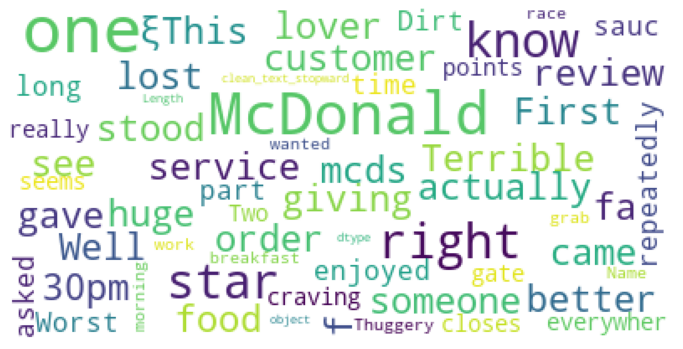

In [36]:
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df['clean_text_stopward']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

# Visualize the top words per topic (their overall frequency in the original doc vs their frequency in the topic)

In [37]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model,doc_word , vectorizer, mds='tsne')
panel

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

2021-12-29 12:34:24,672 : INFO : NumExpr defaulting to 8 threads.
C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:349: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5     -108.958252 -208.941483       1        1  29.386704
1      186.487061  -98.103249       2        1  19.559562
7       19.245832  160.858780       3        1  16.109097
0      170.658829   75.445076       4        1   9.592392
6       -1.386411  -35.043739       5        1   8.315845
2     -145.800095  106.944611       6        1   7.719412
4       64.834541 -221.825272       7        1   5.074361
3     -196.906036  -58.990913       8        1   4.242628, topic_info=          Term        Freq       Total Category  logprob  loglift
4448  mcdonald  748.000000  748.000000  Default  30.0000  30.0000
1472    coffee  230.000000  230.000000  Default  29.0000  29.0000
6357   service  476.000000  476.000000  Default  28.0000  28.0000
5036     order  774.000000  774.000000  Default  27.0000  27.0000
583      asked  157.000000  157.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1144      came    7.447260  107.846347   Topic8  -5.8968   0.4871
7663        ve    8.478389  284.247536   Topic8  -5.7671  -0.3523
1472    coffee    8.052018  230.295786   Topic8  -5.8187  -0.1935
5263    people    8.193567  310.698742   Topic8  -5.8013  -0.4755
7289      time    7.566055  475.806004   Topic8  -5.8810  -0.9814

[699 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
35        1  0.071105     11
35        2  0.142210     11
35        3  0.142210     11
35        4  0.142210     11
35        5  0.071105     11
...     ...       ...    ...
8439      8  0.017024   ξthe
8483      1  0.245829  ξwant
8483      7  0.491659  ξwant
8493      2  0.713944  ξwhat
8493      5  0.203984  ξwhat

[1726 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 8, 1, 7, 3, 5, 4])

# Show the top words for each topic in a dataframe¶

In [38]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Word 0     Word 1     Word 2     Word 3    Word 4     Word 5  \
Topic 0    coffee   mcdonald      place       like      food       good   
Topic 1      food   mcdonald      order      drive      like      fries   
Topic 2  mcdonald  mcdonalds       food       like      time   location   
Topic 3   service      order      drive       food     asked    manager   
Topic 4  mcdonald       time       food  mcdonalds     order  breakfast   
Topic 5     order      drive    service       food  mcdonald  mcdonalds   
Topic 6  mcdonald       food       like    service      time     people   
Topic 7     order       food  mcdonalds      drive  location       time   

            Word 6     Word 7     Word 8   Word 9   Word 10   Word 11  \
Topic 0         ve  mcdonalds      drive      got      time     staff   
Topic 1       fast       time  mcdonalds    place  location    people   
Topic 2      place       good      fries       ve   service     drive   
Topic 3   mcdonald      place        say     like     wrong  customer   
Topic 4      worst     orders       like    drive     sauce  location   
Topic 5       time     window      place  minutes  customer      line   
Topic 6  breakfast    biscuit      place      egg     drive      ξthe   
Topic 7     people      place    service    right  mcdonald      like   

          Word 12   Word 13 Word 14  
Topic 0  location   service  inside  
Topic 1   ordered       got    went  
Topic 2    people     think    make  
Topic 3    cheese  location     way  
Topic 4    coffee    people    work  
Topic 5      like        ve    wait  
Topic 6   ordered     fries     way  
Topic 7    really     times      ve

# CorEx

In [39]:
# Install CorEx 
!pip install corextopic
!pip install networkx

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [40]:
import scipy.sparse as ss

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [41]:
# n_hidden is the number of topics
# words is your list of words used in your corpus
# I recommend adding docs=df.data to make it easier to check which sentences are in each resulting topic
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=df.clean_text_stopward)

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [42]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: ordered,order,said,window,bag,time,asked,got,told,know
1: recent,dont,old,write,children,chaotic,numbers,staying,friends,building
2: pretty,mcdonald,review,walked,visit,mcd,case,ξthis,week,thing
3: exit,star,cash,turn,customers,trying,ξand,lanes,ξit,ξi
4: line,manager,place,store,later,new,work,think,guy,fact
5: egg,sausage,cheese,ξthe,biscuit,wrong,mcmuffin,bacon,black,hash


C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [43]:
topic_model.get_top_docs(topic=4, n_docs=2)

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[("Its mcdonalds. The food flash frozen boxed prepared lesser skilled persons hope spit food. The reason im writing review cos worst one I've ever life. Got screamed homeless lady I walking 'what I gonna lunch?!' Inside ac packed sweaty/nasty. 3 homeless guys harassing everyone line money *not food* bad hitting us over... nobody asked leave. Will never come again. Convinced unspoken level Dante's inferno...",
  0.0),
 ("This WORST McDonalds within 3,000 mile radius. The staff young, rude, untrained kids local middle school drive-through really painfull. This location closed sold someone knows run McDonalds. They're always something, there's never cashier first drive- window (where supposed pay) people sit cars wait cashier magically appear take money..not happening! So decide walk order thinking get order faster missing something..WRONG! As stand wait make bag order watching car would behind you, drive-through, leave. WTF! Next time, I'm getting Mexican food!",
  0.0)]

In [44]:
predictions = pd.DataFrame(topic_model.predict(doc_word), columns=['topic'+str(i) for i in range(6)])
predictions.head(3)

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic0  topic1  topic2  topic3  topic4  topic5
0   False   False   False   False   False   False
1   False   False   False   False   False   False
2    True   False   False    True   False   False

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



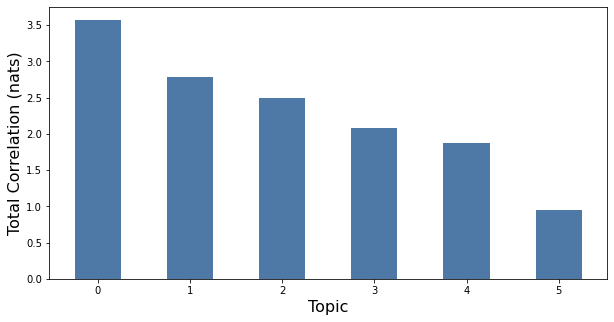

In [45]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [46]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df.clean_text_stopward, 
                anchors=[['food', 'fast', 'drink'], 
                         ['macdonalds'], 
                         [''], 
                         [' lunch', 'frozen'],
                         ['order'], 
                         ['Mexican ','friends', 'car']], anchor_strength=2)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0: food,fast,know,like,drink,mcdonald,review,think,restaurant,little
1: sausage,breakfast,egg,bathroom,biscuit,macdonalds,cheese,eggs,ξno,mcmuffin
2: frozen,course,folks,half,new,butter,individual,bother,buy,ξyou
3: order,window,wrong,ordered,time,asked,right,told,waiting,drive
4: car,friends,guy,minute,big,needed,able,money,experience,trying
5: chicken,sauce,ξi,ve,meat,place,change,sandwich,grilled,experiences


In [47]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df.clean_text_stopward, 
                anchors=[['Mcdonalds', 'worst'], 'drink'], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0: worst,mcdonalds,service,run,wrong,far,absolutely,incompetent,fourth,constant
1: drink,ordered,like,said,finally,took,receipt,pulled,asked,point
2: people,homeless,hours,night,entrance,exit,lot,blue,god,use
3: pounder,quarter,mickey,lets,sunday,fish,handle,process,power,game
4: review,course,sure,probably,stand,used,nearby,write,ok,obvious
5: know,order,counter,pay,way,window,think,time,line,food


# Cluster 

In [48]:
pip install fasttext

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Running setup.py clean for fasttext
Failed to build fasttext
    Running setup.py install for fasttext: started
    Running setup.py install for fasttext: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\njood\Anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\njood\\AppData\\Local\\Temp\\pip-install-5m9t0bab\\fasttext_534f12d605634e07a4809880014e9e13\\setup.py'"'"'; __file__='"'"'C:\\Users\\njood\\AppData\\Local\\Temp\\pip-install-5m9t0bab\\fasttext_534f12d605634e07a4809880014e9e13\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\njood\AppData\Local\Temp\pip-wheel-zxmum6yi'
       cwd: C:\Users\njood\AppData\Local\Temp\pip-install-5m9t0bab\fasttext_534f12d605634e07a4809880014e9e13\
  Complete output (19 lines):
  C:\Users\njood\Anaconda3\lib\site-packages\setuptools\dist.py:723: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' 

In [49]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [59]:
X = df_document_topics.copy()
X.head()

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  \
Doc0    0.96    0.01    0.01    0.01    0.01    0.01    0.01    0.01   
Doc1    0.00    0.00    0.32    0.00    0.00    0.65    0.00    0.00   
Doc2    0.00    0.00    0.00    0.00    0.53    0.46    0.00    0.00   
Doc3    0.02    0.02    0.02    0.87    0.02    0.02    0.02    0.02   
Doc4    0.00    0.99    0.00    0.00    0.00    0.00    0.00    0.00   

      dominant_topic  
Doc0               0  
Doc1               5  
Doc2               4  
Doc3               3  
Doc4               1

In [60]:
ss = StandardScaler()
X_std = ss.fit_transform(d)

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [61]:
inertia_list = []
sil_list = []
k_list = []
for k in range(2, 10):
    km = KMeans(n_clusters = k, random_state=42)
    cluster_labels = km.fit_predict(X_std)
    k_list.append(k)
    inertia_list.append(km.inertia_)
    
    sil_avg = silhouette_score(X_std, cluster_labels)
    sil_list.append(sil_avg)

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will 

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`n

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`n

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`n

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



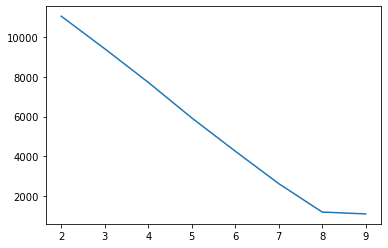

In [62]:
plt.plot(k_list, inertia_list)

In [63]:
for k, sil in zip(k_list, sil_list):
    print(k, sil)

2 0.33904368371205496
3 0.348564263520305
4 0.3927084574857386
5 0.5085963286386339
6 0.5957344940256917
7 0.6812457285498275
8 0.7241363864365038
9 0.6630838647029251


C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [64]:
km = KMeans(n_clusters=8,random_state=10)
km.fit(X_std)

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\njood\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will 

KMeans(random_state=10)

In [65]:
d["cluster"]=km.predict(X_std)
d

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  \
Doc0       0.96    0.01    0.01    0.01    0.01    0.01    0.01    0.01   
Doc1       0.00    0.00    0.32    0.00    0.00    0.65    0.00    0.00   
Doc2       0.00    0.00    0.00    0.00    0.53    0.46    0.00    0.00   
Doc3       0.02    0.02    0.02    0.87    0.02    0.02    0.02    0.02   
Doc4       0.00    0.99    0.00    0.00    0.00    0.00    0.00    0.00   
...         ...     ...     ...     ...     ...     ...     ...     ...   
Doc1520    0.01    0.01    0.01    0.01    0.01    0.31    0.01    0.62   
Doc1521    0.51    0.01    0.01    0.01    0.01    0.44    0.01    0.01   
Doc1522    0.46    0.51    0.00    0.00    0.00    0.00    0.00    0.00   
Doc1523    1.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
Doc1524    0.33    0.66    0.00    0.00    0.00    0.00    0.00    0.00   

         cluster  
Doc0           3  
Doc1           2  
Doc2           7  
Doc3           6  
Doc4           4  
...          ...  
Doc1520        0  
Doc1521        3  
Doc1522        4  
Doc1523        3  
Doc1524        4  

[1525 rows x 9 columns]

In [69]:
n=pd.DataFrame(km.cluster_centers_,columns=X.columns)
n

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic0    Topic1    Topic2    Topic3    Topic4    Topic5    Topic6  \
0 -0.369372 -0.435595 -0.299742 -0.171241 -0.201792 -0.625556 -0.282468   
1 -0.348153 -0.436506 -0.314997 -0.210730 -0.222841 -0.665132  3.280890   
2 -0.315701 -0.440113 -0.264213 -0.188226 -0.197483  1.442096 -0.248323   
3  2.641381 -0.453288 -0.296827 -0.185764 -0.244732 -0.591971 -0.299790   
4 -0.324520  2.038153 -0.260155 -0.180794 -0.212671 -0.614034 -0.260833   
5 -0.389839 -0.444422  3.280304 -0.208698 -0.241721 -0.644392 -0.323892   
6 -0.375893 -0.497398 -0.319260  4.829980 -0.195960 -0.627738 -0.320647   
7 -0.287631 -0.418744 -0.308867 -0.196407  4.164882 -0.528459 -0.296203   

     Topic7  dominant_topic  
0  2.141549       -0.925781  
1 -0.450326        0.558778  
2 -0.388887       -0.430928  
3 -0.420669        2.043338  
4 -0.459020        0.063925  
5 -0.455325       -1.420634  
6 -0.460261        1.548484  
7 -0.432343        1.053631

In [70]:
n.to_csv("Njd2.csv")

C:\Users\njood\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

